In [1]:
import sys
import torchio as tio
import pandas as pd 
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm


sys.path.insert(0, '../../scripts/')
import data_loader
from helpers import miscellaneous as misc
from helpers import preprocessing2d as prep

CONFIG = misc.get_config()

In [2]:
CONFIG

{'RAW_DATA_DIR': 'data/raw/',
 'PROCESSED_DATA_DIR': 'data/processed/',
 'FLATTENED_DATA_DIR': 'data/raw/flattened/',
 'SERIALIZED_MODELS': 'models/trained_models/',
 'METRICS_DIR': 'models/trained_history/',
 'ANNOTATIONS_DIR': 'data/annotations/',
 'CDR_DIR': 'data/tabular_data/tabular_data/CDR.csv',
 'GDSCALE_DIR': 'data/tabular_data/tabular_data/GDSCALE.csv',
 'MMSE_DIR': 'data/tabular_data/tabular_data/MMSE.csv',
 'MOCA_DIR': 'data/tabular_data/tabular_data/MOCA.csv',
 'NEUROBAT_DIR': 'data/tabular_data/tabular_data/NEUROBAT.csv',
 'PTDEMOG_DIR': 'data/tabular_data/tabular_data/PTDEMOG.csv',
 'TRAIN_LABELS_DIR': 'data/annotations/train_labels.csv',
 'TEST_LABELS_DIR': 'data/annotations/test_labels.csv',
 'PLOT_DIR_BINARY': 'reports/plots/',
 'SLICED_DATA_DIR': 'data/raw/slices/',
 'MODEL': 'DenseNet121',
 'DEVICE': 'gpu',
 'TRAIN_SIZE': 0.8,
 'LEARNING_RATE': 0.001,
 'AUTO_LEARNING_RATE': True,
 'BATCH_SIZE': 32,
 'AUTO_BATCH_SIZE': False,
 'EPOCHS': 30,
 'NUM_WORKERS': 6,
 'TRANS

In [3]:
SLICE = CONFIG['NSLICE']
DIMENSION = CONFIG['DIMENSION']
TRANSFORMER = CONFIG['TRANSFORMER']

In [4]:
train_data = pd.read_csv('../../' + CONFIG['TRAIN_LABELS_DIR'])
test_data = pd.read_csv('../../' + CONFIG['TEST_LABELS_DIR'])

train_transform, val_transform = prep.get_transformer(TRANSFORMER)

In [5]:
def imshow(img):
    plt.imshow(img)
    
def save_slices(annotations, transform):
    
    for i in tqdm(range(len(annotations))):
        filename = annotations.filename.iloc[i]
        if isinstance(filename, str):
            name = filename.split('\\')[1]
            #name = name.replace('.nii', '.png')
        else:
            continue

        img = tio.ScalarImage("../../" + filename)
        
        if SLICE == 'Center':
            nslice = img.data.size(DIMENSION)//2 #add more parameters for different slices, for example: 10%, 20%
        else:
            nslice = SLICE
        
        if SLICE:
            if DIMENSION == 1:
                assert img.data.size()[1] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[1]}'
                img = img.data[:, nslice, :, :]
            elif DIMENSION == 2:
                assert img.data.size()[2] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[2]}'
                img = img.data[:, :, nslice, :]
            elif DIMENSION == 3:
                assert img.data.size()[3] >= nslice, f'[WARN] Nslice is too large. Max allowed: {img.data.size()[3]}'
                img = img.data[:, :, :, nslice]
        if i == 1:
            print("image size before transform: ", img.shape)
        img = transform(img.unsqueeze(dim=3))
        if i == 1:
            print("image size after transform: ", img.shape)
        """img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        npimg = np.squeeze(npimg)
        img = Image.fromarray(img.numpy()).uint8(I)"""
        img = tio.ScalarImage(tensor=img)
        img.save("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/{DIMENSION}/' + name + ".nii")

# trainset
save_slices(train_data, train_transform)
save_slices(test_data, val_transform)

  0%|          | 0/1824 [00:00<?, ?it/s]

torch.Size([1, 192, 160])
torch.Size([1, 256, 256, 1])


  0%|          | 0/470 [00:00<?, ?it/s]

torch.Size([1, 192, 160])
torch.Size([1, 256, 256, 1])


## Dimension 1:

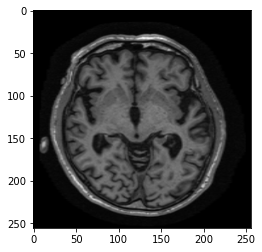

In [6]:
test_img_processed = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/1/' + "ADNI_136_S_0695_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008134904920_S19019_I119736" + ".nii")
plt.imshow(test_img_processed.data[0,:,:,0], cmap="gray")
plt.show()

## Dimension 2:

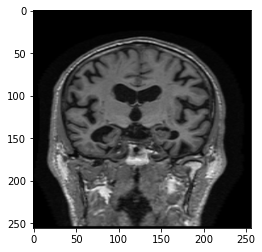

In [7]:
test_img_processed = tio.ScalarImage("../../" + CONFIG['SLICED_DATA_DIR'] + f'center/2/' + "ADNI_136_S_0695_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008134904920_S19019_I119736" + ".nii")
plt.imshow(test_img_processed.data[0,:,:,0], cmap="gray")
plt.show()